#### Import Libraries

In [1]:
!pip install gensim
!pip  install -U farasapy
!pip install wordcloud matplotlib arabic-reshaper python-bidi
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=d19c2900577593b1b826da2ab85a842087cb56d662c408ca84af70abb31cce16
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
import re
from nltk.stem import ARLSTem
from farasa.stemmer import FarasaStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import arabic_reshaper
from bidi.algorithm import get_display
import langid

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Read Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/dataset/dataset_v2.csv')

In [7]:
df.columns

Index(['Unnamed: 0.1', 'F1', 'court', 'city', 'court_id', 'court_date',
       'appeal_court', 'region', 'appeal_id', 'appeal_date', 'judgment_text',
       'appeal_text', 'Unnamed: 0', 'links', 'appeal_data', 'appleal_text',
       'judgment_regex', 'cases_text'],
      dtype='object')

#### Cleaning

In [ ]:
df = df[df["cases_text"].notnull()]

In [ ]:
# Get the set of Arabic stop words
stop_words = set(stopwords.words('arabic'))

# Words to be removed
to_remove = {"الحمد" ,"لله","والصلاة","السلام","رسول", "القاضي", "رئيسا", "عضوا", "الدائرة",
             "وبناءً" ,"القضية", "رئيس" ,"وصلى", "ﷲ"," وسلم"," نبينا", "محمد", "وآله"," وصحبه" ,"أجمعين", "وبﷲ", "والسلام"
             ,"التوفيق", "المدعي"," عليها", "هوية"," وطنية", "إلزام" , "منطوق" ,"الحكم","جلسة", "وكيل"," المدعية", "وكالة","حكم"
             ,"رقم", "حكمت", "العام", "موكلتي", "صحيفة", "الدعوى", "تاريخ","بموجب","وكالة", "حضر" ,"وكيل","المدعى","جلسة", "هوية","وطنية",
             "سجل","تجاري"}

# Combine the two sets
stop = stop_words | to_remove

# Initialize Farasa stemmer
stemmer = FarasaStemmer(interactive=True)

# Apply stemming to each word in to_remove
stop = set(stemmer.stem(' '.join(stop)).split())


# Print the combined set of stop words
print(stop)

[2023-12-01 19:25:09,302 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


{'واو', 'طال', 'عدا', 'مادام', 'عدس', 'موكل', 'هو', 'يناير', 'اتخذ', 'قضية', 'غداة', 'وجد', 'متى', 'شيقل', 'ت', 'أولالك', 'عاد', 'ثالث', 'ظن', 'أن', 'ي', 'آن', 'أحد', 'عجب', 'حق', 'هاء', 'سحق', 'نبي', 'فوق', 'هم', 'هما', 'ثماني', 'تل', 'آي', 'ذال', 'ذوات', 'مهما', 'جيم', 'اربع', 'هل', 'ها', 'حبذا', 'آب', 'بس', 'ثامن', 'أصل', 'ترك', 'تعلم', 'أكثر', 'قرش', 'كلي', 'حكم', 'جير', 'فلان', 'لكنما', 'عن', 'قاف', 'فلس', 'خمس', 'خ', 'قام', 'عسى', 'أقل', 'اثنان', 'نا', 'زود', 'كان', 'لدى', 'ستمائة', 'ف', 'على', 'ص', 'سبع', 'أعلم', 'أجل', 'ضحوة', 'سبعمئة', 'مرة', 'هج', 'لم', 'وهب', 'حاش', 'انفك', 'أطعم', 'بخ', 'أخذ', 'حمد', 'سبعون', 'أصبح', 'غد', 'حج', 'عضو', 'أنى', 'إلزام', 'أخبر', 'شين', 'دعوى', 'بين', 'يمين', 'درى', 'سنتيم', 'ماذا', 'وي', 'صراحة', 'اخلولق', 'إزاء', 'هكذا', 'معاذ', 'قبل', 'ثلاثون', 'ولي', 'حبيب', 'هن', 'كيفما', 'دائرة', 'همزة', 'هي', 'نخ', 'إذا', 'سلام', 'بلى', 'ثمنمئة', 'يورو', 'نحو', 'كما', 'أربع', 'ست', 'حرى', 'ارتد', 'مليم', 'ﷲ', 'ياء', 'استحال', 'ث', 'اللائي', 'أيار', 'تعس'

In [ ]:
# Function to remove stop words from a given text
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop]
    return ' '.join(filtered_words)

In [ ]:
class Processor_simi:
    def __init__(self):
        arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
        english_punctuations = string.punctuation
        self.all_punctuations = set(arabic_punctuations + english_punctuations)

        # Initialize Farasa stemmer for stemming
        self.stemmer = FarasaStemmer(interactive=True)

    def normalize_arabic(self, text):
        # Remove Arabic digits
        text = re.sub("[٠١٢٣٤٥٦٧٨٩]", "", text)
        text = re.sub("[0123456789]", "", text)

        # Remove English digits, slashes, and all punctuations
        text = re.sub(r'[\d/]+', '', text)
        text = re.sub(f'[{re.escape("".join(self.all_punctuations))}]', '', text)

        # Normalize Arabic characters
        text = re.sub("[إأآاٱ]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ؤ", "ء", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("ة", "ه", text)
        text = re.sub("گ", "ك", text)
        text = re.sub(r'\bال(\w\w+)', r'\1', text)
        text = re.sub(r'\sو(\w+)', r' و \1', text)
        text = re.sub(r'[()\.:\'/<>،`,]', '', text)
        text = re.sub(r'[0-9٠-٩]', '', text)
        return text

        # Remove remaining digits
        text = re.sub("\u0640", '', text)

        return text

    def stem_and_process(self, text):
        # Use Farasa stemmer for stemming

        stemmed_text = self.stemmer.stem(text)

        return stemmed_text

# Create an instance of the text processor
text_processor_simi = Processor_simi()

[2023-12-01 19:25:12,434 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
df['text_for_simi']=df['cases_text'].apply(lambda x: re.sub(r'\s+', ' ', x))
df['text_for_simi']=df['text_for_simi'].apply(lambda x: re.sub(r"[)(><.:',،`]", ' ', x))

In [ ]:
df["text_for_simi"] = df['text_for_simi'].apply(lambda x: text_processor_simi.stem_and_process(x))
df["text_for_simi"] = df['text_for_simi'].apply(lambda x: text_processor_simi.normalize_arabic(x))

In [ ]:
df["text_for_simi"] = df["text_for_simi"].apply(lambda x: remove_stopwords(x))

In [ ]:
def remove_english_words(text):
    words = word_tokenize(text)
    non_english_words = [word for word in words if not any(c.isalpha() and c.isascii() for c in word)]
    return ' '.join(non_english_words)
df['text_for_simi'] = df['text_for_simi'].apply(remove_english_words)

In [ ]:
df.drop(df[df['text_for_simi'].isnull()].index, inplace=True)

In [ ]:
#df.to_csv('/content/drive/MyDrive/dataset/dataset_v3.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/dataset_v3.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2228 non-null   int64  
 1   F1              1897 non-null   object 
 2   court           2228 non-null   object 
 3   city            2195 non-null   object 
 4   court_id        2228 non-null   object 
 5   court_date      2228 non-null   object 
 6   appeal_court    1397 non-null   object 
 7   region          1364 non-null   object 
 8   appeal_id       1397 non-null   object 
 9   appeal_date     1364 non-null   object 
 10  judgment_text   2228 non-null   object 
 11  appeal_text     1364 non-null   object 
 12  Unnamed: 0      331 non-null    float64
 13  links           331 non-null    object 
 14  appeal_data     33 non-null     object 
 15  appleal_text    33 non-null     object 
 16  judgment_regex  2228 non-null   object 
 17  cases_text      2228 non-null   o

#### Fine-tuning of Word2vec

In [ ]:
df['text_for_word2vec'] = df['cases_text'].astype(str)

In [ ]:
def remove_numbers(text):
    # Use regex to remove Arabic and English numbers
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

# Apply the function to the 'TextColumn'
df['text_for_word2vec'] = df['text_for_word2vec'].apply(remove_numbers)

In [ ]:
df['text_for_word2vec']=df['text_for_word2vec'].apply(lambda x: re.sub(r'\s+', '', x))
df['text_for_word2vec']=df['text_for_word2vec'].apply(lambda x: re.sub(r"[)(><.:',،`//\\?؟؛]", ' ', x))

In [ ]:
to_remove = ["الحمد لله" ,  "والصلاة"," والسلام ","على رسول ﷲ" , "القاضي" , "رئيسا" , "عضوا" , "وبناءً القضية" , "رئيس الدائرة" ,
  "وصلى ﷲ وسلم نبينا محمد وآله وصحبه أجمعين"
  , "وبﷲ التوفيق و" , "أما بعد" ,"سجل تجاري", "سجل تجاري رقم" , "سجل مدني رقم" , "للمقاولات" , "المقاولات" , "الديكور الداخلي", "المحدودة"]

for sentence in to_remove:
  df['text_for_word2vec'] = df['text_for_word2vec'].str.replace(sentence, '')

stop_words = set(stopwords.words('arabic'))

df['text_for_word2vec'] = df['text_for_word2vec'].apply(lambda text: ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words]))

In [ ]:
def remove_english_words(text):
    words = word_tokenize(text)
    non_english_words = [word for word in words if not any(c.isalpha() and c.isascii() for c in word)]
    return ' '.join(non_english_words)
df['text_for_word2vec'] = df['text_for_word2vec'].apply(remove_english_words)

In [ ]:
# Train Word2Vec model on the judgment texts
tokenized_texts = [text.split() for text in df['text_for_word2vec']]
# word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a text
def get_text_vector(text, model):
    vector = [model.wv[word] for word in text.split() if word in model.wv]
    return np.mean(vector, axis=0) if vector else np.zeros(model.vector_size)

In [ ]:
# Create your Word2Vec model
my_model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Build the vocabulary of your model
my_model.build_vocab(tokenized_texts)

# Set vectors_lockf to ones
my_model.wv.vectors_lockf = np.ones(len(my_model.wv))

# Load the pre-trained Word2Vec model
#pretrained_model = Word2Vec.load('/content/drive/MyDrive/Data/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl')
#pretrained_model.wv.save_word2vec_format('/content/drive/MyDrive/Data/full_grams_sg_100_wiki/full_grams_sg_100_wiki.bin', binary=True)

# Intersect the vocabularies
my_model.wv.intersect_word2vec_format('/content/drive/MyDrive/Data/full_grams_sg_100_wiki/full_grams_sg_100_wiki.bin', binary=True)

# Update the weights of the common words in your model with the weights from the pre-trained model
my_model.build_vocab([list(my_model.wv.key_to_index.keys())], update=True)

# Train your model on your data
my_model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=20)

(29149580, 29149580)

In [ ]:
# Save Word2Vec model
combined_model_path = '/content/drive/MyDrive/dataset/word2vec_model.txt'
my_model.save(combined_model_path)

In [8]:
# Load Word2Vec model
combined_model_path = '/content/drive/MyDrive/dataset/word2vec_model.txt'
similarity_model = Word2Vec.load(combined_model_path)

In [9]:
similarity_model_words = similarity_model.wv.key_to_index.keys()
len(similarity_model_words)

52754

In [ ]:
similarity_model_words

In [ ]:
similarity_model_words = [word for word in similarity_model_words if len(word) > 1]
print(similarity_model_words)

['المدعى', 'الدائرة', 'عليها', 'الدعوى', 'المدعي', 'رقم', 'المدعية', 'وكيل', 'الحكم', 'التجارية', 'القضية', 'مبلغ', 'شركة', 'بأن', 'العقد', 'بتاريخ', 'جلسة', 'دعوى', 'الجلسة', 'تم', 'وفي', 'أنه', '``', 'الشركة', 'وكالة', 'المادة', 'طلب', 'قدره', 'المحكمة', 'حضر', 'نظام', 'بن', 'المبلغ', 'بموجب', 'وحيث', 'عدم', 'وقدره', 'وقد', 'بمبلغ', 'إلزام', 'لعام', 'عقد', 'ولم', 'تاريخ', 'تقدم', 'الطرفين', 'وبناء', 'قيمة', 'وطنية', 'وبما', 'موكلتي', 'المحاكم', 'هوية', 'محمد', 'وذلك', 'وتاريخ', 'ولما', 'بعدم', 'الوقائع', 'محل', 'عضو', 'للمدعى', 'الأسباب', 'وأن', 'منطوق', 'جاء', 'وعليه', 'موكلته', 'بأنه', 'المقامة', 'مؤسسة', 'موكله', 'ذكر', 'موكلي', 'المطالبة', 'مذكرة', 'دعواه', 'وقائع', 'بدفع', 'وبعد', 'قررت', 'فلدى', 'مبلغا', 'خلال', 'حكمت', 'سبق', 'معه', 'الأعمال', 'رأس', 'قدم', 'تبين', 'نصت', 'تنتهي', 'مدعى', 'قبول', 'صحيفة', 'كانت', 'الصادر', 'المشار', 'أتعاب', 'إليه', 'ضد', 'الخبير', 'بناء', 'المال', 'وبسؤال', 'المشروع', 'المحاماة', 'رفع', 'بسداد', 'بإلزام', 'والتي', 'حكم', 'للمدعي', 'ألفا', 'عب

##### test model

In [11]:
similarity_model.wv.most_similar('مدعي', topn=5)

[('متداعيان', 0.7554441094398499),
 ('بالترافع', 0.6884254813194275),
 ('قاض', 0.6711035370826721),
 ('قضائي', 0.6602309346199036),
 ('بالاستئناف', 0.6537321209907532)]

In [ ]:
word1 = 'مدعي'
word2 = 'قاض'

if word1 in similarity_model.wv.key_to_index.keys() and word2 in similarity_model.wv.key_to_index.keys():
    # Get vector representations
    vector_representation1 = similarity_model.wv[word1].reshape(1, -1)
    vector_representation2 = similarity_model.wv[word2].reshape(1, -1)

    # Calculate cosine similarity
    similarity = cosine_similarity(vector_representation1, vector_representation2)[0, 0]

    print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")
else:
    print("One or both words not in vocabulary.")


Cosine Similarity between 'مدعي' and 'قاض': 0.6711035370826721


In [25]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE


output_notebook()
plot_chart = bp.figure(width=700, height=600, title="A map/plot of 5000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_type=None, y_axis_type=None, min_border=1)

word_vectors = [similarity_model.wv[w] for w in list(similarity_model.wv.key_to_index.keys())[0:5000]]
word_vectors_np = np.array(word_vectors)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors_np)

tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(similarity_model.wv.key_to_index.keys())[0:5000]
plot_chart.scatter(x='x', y='y', source=tsne_df)
hover = plot_chart.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_chart);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.028212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.019775
[t-SNE] KL divergence after 1000 iterations: 2.635848


In [41]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)

In [48]:
similarity_model.wv.most_similar('قضيه', topn=5)

[('قضايا', 0.8343559503555298),
 ('القضايا', 0.7625967264175415),
 ('لقضيه', 0.7618221640586853),
 ('قضيته', 0.7443540692329407),
 ('دعاوي', 0.7095037698745728)]

In [67]:
words_to_visualize = ["أموالهم","بأرباح","بالدين","مذهب","يماطل","يمانع",'مدعي',
                      "قضيه","الايميل","بياناتهم","ملف","دعاوي","الديون","تقسيط","قضايا",
                      'بالترافع',"المحامي","المحامين","موكله","الشهود","الحادث", 'بالاستئناف',
                      "اجتماعات","سداد","للدائنين","القرض","سدادها","المدعي","بقيمة","غرامة",
                      "اجمالية","المعاملات","الشراء","وثائق","مستندات","سجلات"]
embeddings = [similarity_model.wv[word] for word in words_to_visualize]

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_array = np.array(embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # You can adjust 5 to a suitable value
embeddings_2d = tsne.fit_transform(embeddings_array)

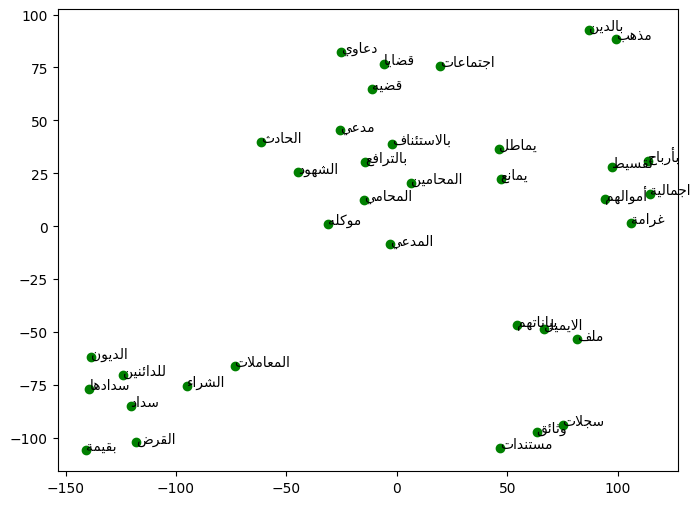

In [75]:
import matplotlib.pyplot as plt
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color= 'green')

for i, word in enumerate(words_to_visualize):
    plt.annotate(handle_arabic(word) ,(embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


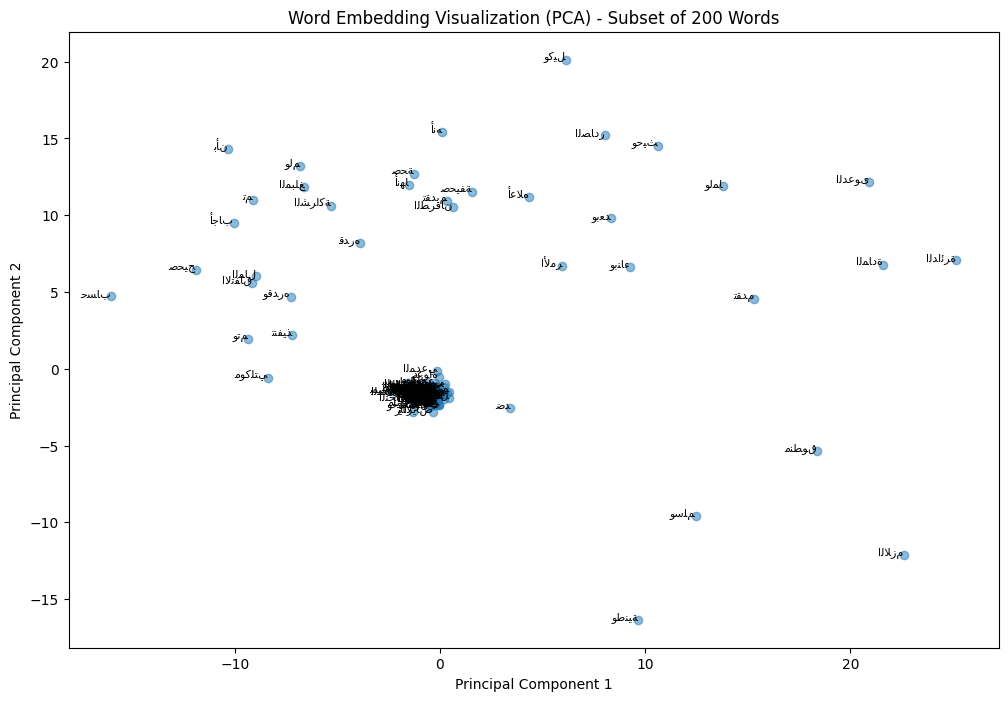

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from arabic_reshaper import reshape



# Get a subset of words and their vectors
subset_words = list(similarity_model.wv.key_to_index.keys())[:200]
subset_word_vectors = np.array([similarity_model.wv[word] for word in subset_words])

# Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(subset_word_vectors)

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1], alpha=0.5)

# Annotate points with reshaped Arabic words
for i, word in enumerate(subset_words):
    reshaped_word = reshape(word)
    plt.annotate(reshaped_word, xy=(result[i, 0], result[i, 1]), fontsize=8, ha='right')  # Adjust 'ha' for proper alignment

plt.title("Word Embedding Visualization (PCA) - Subset of 200 Words")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


#### Similarity using Word2vec

In [ ]:
# Function to get the vector representation of a text
def get_text_vector(text, model):
    vector = [model.wv[word] for word in text.split() if word in model.wv]
    return np.mean(vector, axis=0) if vector else np.zeros(model.vector_size)

In [ ]:
input_text = "التأخير في رفع المستحقات"
input_text = remove_stopwords(input_text)
judgment_vectors = [get_text_vector(text, similarity_model) for text in df['text_for_simi']]
input_vector = get_text_vector(input_text, similarity_model)
similarity_values = cosine_similarity([input_vector], judgment_vectors).flatten()
similarity_list = [(i, similarity_values[i], df['judgment_text'].iloc[i]) for i in range(len(similarity_values))]

# Sort the list by similarity values and get the top 3
top_similarity_list = sorted(similarity_list, key=lambda x: x[2], reverse=True)[:3]

# Create a DataFrame from the top similarity list
result_df = pd.DataFrame(top_similarity_list, columns=['index', 'similarity_values', 'judgment_text'])

# Print the DataFrame
result_df


,index,similarity_values,judgment_text
0,1662,0.632023,لحمد لله والصلاة والسلام على رسول ﷲ أما بعد:\n...
1,625,0.632247,لحمد لله والصلاة والسلام على رسول ﷲ أما بعد:\n...
2,1405,0.658921,حكم غيابي في القضية رقم ٣٩٤/٢/ق لعام ١٤٣٩ه\nال...


#### WordCloud

In [ ]:
# Load the pre-trained Word2Vec model
pretrained_model = Word2Vec.load('/content/drive/MyDrive/Data/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl')
pretrained_model_words = set(pretrained_model.wv.key_to_index.keys())

In [ ]:
len(pretrained_model_words)

662109

In [ ]:
pretrained_model_words

{'فوزي_القاوقجي',
 'ومزدهرا',
 'الشهر_فليصمه_ومن',
 'يستشف',
 'المعرض_لاول_مره',
 'ووال',
 'وفسح_المجال',
 'منشار',
 'الديانه_الرسميه_للدوله',
 'ومزرعه',
 'شريف_سلامه',
 'الرئيس_الحبيب_بورقيبه',
 'مركز_جونز_هوبكنز',
 'يزيد_بن_خصيفه',
 'العوالم_السفليه',
 'والابحاث_المتعلقه',
 'اوف_لاين',
 'اظهر_اهتماما',
 'مقياس_لقدره',
 'ايكه',
 'ازجي',
 'مارف',
 'هرمان_هسه',
 'يحتاجها_الانسان',
 'هوتين',
 'يدعوك',
 'ونائيه',
 'الشاعر_الاديب',
 'لدار_الافتاء',
 'والبرديات',
 'الهرمونات_الذكريه',
 'برنامجا_للاصلاح',
 'سليمان_المستعين_بالله',
 'تشاتانوغا',
 'لصحيفته',
 'خدم_سورون',
 'تعليما',
 'مرحله_السطوح',
 'كيلومترا_جنوب_شرقي',
 'الماثورات',
 'ميدان_الاسماعيليه',
 'مؤخره_جيش',
 'بزمن_قدره',
 'انيزي',
 'ı',
 'الكوجيتو',
 'تعمل_بمحرك',
 'المخزن_المؤقت',
 'بالجذر',
 'ابا_فراس',
 'اولاد_معرف',
 'قسيطل',
 'للمجفف',
 'كوي_سنجق',
 'عندما_اطيح',
 'المطبخ_التركي',
 'حصان_وتبلغ_السرعه',
 'بيتيكا',
 'وانعدام',
 'تملكها',
 'كلفهم',
 'والعقليه_والاجتماعيه',
 'والاوجه',
 'القداما',
 'ارجاء_الدوله_العثمانيه',
 'هب

In [ ]:
# all words in our text
df['text_for_word2vec'] = df['text_for_word2vec'].astype(str)
all_words = [word_tokenize(text) for text in df['text_for_word2vec']]
flat_words = [word for sublist in all_words for word in sublist]
unique_words = set(flat_words)
len(unique_words)

52754

In [ ]:
# Find the intersection
intersection = unique_words.intersection(pretrained_model_words)

percentage_overlap = (len(intersection) / len(unique_words)) * 100

print("Percentage of overlap: {:.2f}%".format(percentage_overlap))
print("Number of common words:", len(intersection))

Percentage of overlap: 53.25%
Number of common words: 28089


In [ ]:
# Instantiate WordCloud object with a different variable name
wordcloud_obj = WordCloud(font_path='/content/drive/MyDrive/alfont_com_Foda-Free-Font.ttf', background_color='white', mode='RGB', width=2000, height=1000)

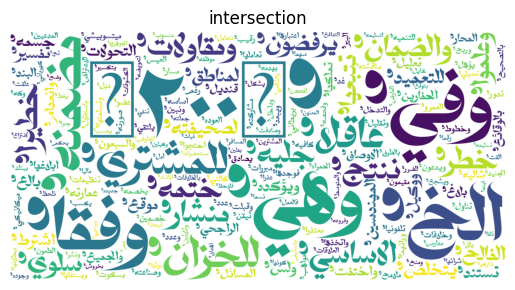

In [ ]:
#intersection
wordcloud_obj.generate(str(intersection))

# Display the word cloud using matplotlib
plt.title("intersection")
plt.imshow(wordcloud_obj)
plt.axis("off")
plt.show()

In [ ]:
# disconnection (not-intersection)
dis = unique_words - intersection
len(dis)

24665

In [ ]:
dis

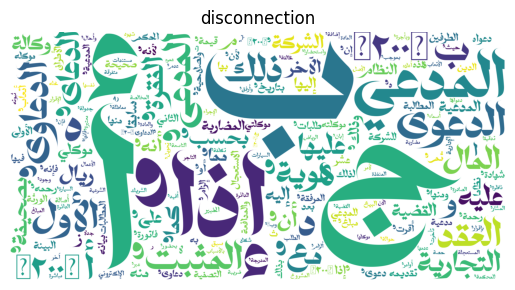

In [ ]:
wordcloud_obj.generate(str(dis))

# Display the word cloud using matplotlib
plt.title("disconnection")
plt.imshow(wordcloud_obj)
plt.axis("off")
plt.show()